In [1]:
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pandas import read_csv
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from numpy import mean
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib
from IPython.display import display, HTML
import pandas

start=0
cfg_list=list()
def measure_rmse(actual, predicted,error=0):
    error=sqrt(mean_squared_error(actual, predicted))
    return error

def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

def sarima_forecast(history, config):
    order, sorder, trend = config
    model = SARIMAX(history, order=order, seasonal_order=sorder, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=False)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = sarima_forecast(history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = measure_rmse(test, predictions)
    return error

def score_model(data, n_test, cfg,count, debug=False):
    result = None
    error_resi=list()
    error_trains=list()
    error_tests=list()
    
    key = (cfg)

    try:
        with catch_warnings():
            filterwarnings("ignore")
            error_tests = walk_forward_validation(data, n_test, cfg)
    except:
        error_tests=10
        
    return (key, error_tests)

def parallel_model(data1,data2,data3,data4,data5, n_test, cfg,count):
    score=[]
    global start
    start=start+1
    
    score1=score_model(data1, n_test, cfg, len(cfg_list))
    score2=score_model(data2, n_test, cfg, len(cfg_list))
    score3=score_model(data3, n_test, cfg, len(cfg_list))
    score4=score_model(data4, n_test, cfg, len(cfg_list))
    score5=score_model(data5, n_test, cfg, len(cfg_list))
    bh1=score1[1]
    bh2=score2[1]
    bh3=score3[1]
    bh4=score4[1]
    bh5=score5[1]

    avg_test=(bh1+bh2+bh3+bh4+bh5)/5
    score=(score1[0],round(bh1,3),round(bh2,3),round(bh3,3),round(bh4,3),round(bh5,3),round(avg_test,5))
    
    if avg_test<10:
        print( '[%s/%s]> Model[%s] [%.5f]' % (int(start/5)+1,count,score1[0],avg_test))
        

    return score

def grid_search(data1,data2,data3,data4,data5, cfg_list, n_test,count, parallel=True):
    scores = []
    
    if parallel:
        executor = Parallel(n_jobs=cpu_count(), backend= 'multiprocessing' )
        tasks = (delayed(parallel_model)(data1,data2,data3,data4,data5, n_test, cfg, count) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        for cfg in cfg_list:
            scores=parallel_model(data1,data2,data3,data4,data5, n_test, cfg, count)
            
    scores = [r for r in scores if r[6] <10]
    scores.sort(key=lambda tup: tup[6])
    return scores 



def find_best_models(data1,data2,data3,data4,data5):

    # data split
    n_test = 16
    count=0
    
    scores=list()
    # # model configs
    cfg_list,count = sarima_configs()    

    # # grid searchech blog

    scores = grid_search(data1,data2,data3,data4,data5, cfg_list, n_test,count)
    df = pandas.DataFrame(scores)
    df.to_csv("output.csv", sep=',',index=False)
    print('-----------------------------------------------------------------------------')
    print('\t \t cfg \t\t BH1  BH2   BH3     BH4    BH5   AVG')
    print('-----------------------------------------------------------------------------')
    for i in range(len(scores)):
        print(scores[i])
    print('-----------------------------------------------------------------------------')   
    return scores




In [31]:
def figure(train1,test1,train2,test2,train3,test3,train4,test4,train5,test5,predictions_train1,predictions_train2,predictions_train3,predictions_train4,predictions_train5,predictions_test1,predictions_test2,predictions_test3,predictions_test4,predictions_test5,error_train1,error_train2,error_train3,error_train4,error_train5,error_test1,error_test2,error_test3,error_test4,error_test5):
    fig= plt.figure(figsize=(14, 25))

    params = {'legend.fontsize': 12,
              'legend.handlelength': 2,
              'font.size': 12}
    plt.rcParams.update(params)

    sub1 = plt.subplot(5, 2, 1)
    plt.plot(train1,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_train1,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TRAIN",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.ylim(-7,2)
    trn_rmse="RMSE: "+str(format(error_train1,'.2f'))
    plt.text(45, -6.5, trn_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "A",fontsize=20,fontweight='bold')
    plt.legend(loc=3,framealpha=0)
    # plt.show()


    sub2 = plt.subplot(5, 2, 2)
    # sub2.set_yticks([1,0,-1,-2,-3,-4,-5,-6])
    plt.plot(test1,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_test1,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TEST",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.legend(loc=3,framealpha=0)
    plt.ylim(-7,2)
    # place a text box in lower right in axes coords
    tst_rmse="RMSE: "+str(format(error_test1,'.2f'))
    plt.text(11, -6.5, tst_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "B",fontsize=20,fontweight='bold')

    sub3 = plt.subplot(5, 2, 3)
    plt.plot(train2,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_train2,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TRAIN",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.ylim(-7,2)
    trn_rmse="RMSE: "+str(format(error_train2,'.2f'))
    plt.text(45, -6.5, trn_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "C",fontsize=20,fontweight='bold')
    plt.legend(loc=3,framealpha=0)
    # plt.show()


    sub4 = plt.subplot(5, 2, 4)
    # sub2.set_yticks([1,0,-1,-2,-3,-4,-5,-6])
    plt.plot(test2,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_test2,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TEST",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.legend(loc=3,framealpha=0)
    plt.ylim(-7,2)
    # place a text box in lower right in axes coords
    tst_rmse="RMSE: "+str(format(error_test2,'.2f'))
    plt.text(11, -6.5, tst_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "D",fontsize=20,fontweight='bold')

    sub5 = plt.subplot(5, 2, 5)
    plt.plot(train3,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_train3,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TRAIN",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.ylim(-7,2)
    trn_rmse="RMSE: "+str(format(error_train3,'.2f'))
    plt.text(45, -6.5, trn_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "E",fontsize=20,fontweight='bold')
    plt.legend(loc=3,framealpha=0)
    # plt.show()


    sub6 = plt.subplot(5, 2, 6)
    # sub2.set_yticks([1,0,-1,-2,-3,-4,-5,-6])
    plt.plot(test3,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_test3,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TEST",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.legend(loc=3,framealpha=0)
    plt.ylim(-7,2)
    # place a text box in lower right in axes coords
    tst_rmse="RMSE: "+str(format(error_test3,'.2f'))
    plt.text(11, -6.5, tst_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "F",fontsize=20,fontweight='bold')

    sub7 = plt.subplot(5, 2, 7)
    plt.plot(train4,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_train4,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TRAIN",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.ylim(-7,2)
    trn_rmse="RMSE: "+str(format(error_train4,'.2f'))
    plt.text(45, -6.5, trn_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "G",fontsize=20,fontweight='bold')
    plt.legend(loc=3,framealpha=0)
    # plt.show()


    sub8 = plt.subplot(5, 2, 8)
    # sub2.set_yticks([1,0,-1,-2,-3,-4,-5,-6])
    plt.plot(test4,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_test4,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TEST",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.legend(loc=3,framealpha=0)
    plt.ylim(-7,2)
    # place a text box in lower right in axes coords
    tst_rmse="RMSE: "+str(format(error_test4,'.2f'))
    plt.text(11, -6.5, tst_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "H",fontsize=20,fontweight='bold')

    sub9 = plt.subplot(5, 2, 9)
    plt.plot(train5,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_train5,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TRAIN",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.ylim(-7,2)
    trn_rmse="RMSE: "+str(format(error_train5,'.2f'))
    plt.text(45, -6.5, trn_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "I",fontsize=20,fontweight='bold')
    plt.legend(loc=3,framealpha=0)
    # plt.show()


    sub10 = plt.subplot(5, 2, 10)
    # sub2.set_yticks([1,0,-1,-2,-3,-4,-5,-6])
    plt.plot(test5,color='orange',linewidth=2,label='Actual Data')
    plt.plot(predictions_test5,'y--',color='black',linewidth=1,label='Predicted Data')
    plt.legend(loc=2, prop={'size': 20})
    # plt.title("SARIMA TEST",fontsize=16)
    plt.xlabel("Weeks",fontsize=20)
    plt.ylabel("Angle (Degree)",fontsize=20)
    plt.axhline(y=0, color='gray', linestyle='-',linewidth=1)
    plt.legend(loc=3,framealpha=0)
    plt.ylim(-7,2)
    # place a text box in lower right in axes coords
    tst_rmse="RMSE: "+str(format(error_test5,'.2f'))
    plt.text(11, -6.5, tst_rmse,fontsize=12,fontweight='bold')
    plt.text(0, 1, "J",fontsize=20,fontweight='bold')

    plt.savefig("SARIMABH.svg",bbox_inches='tight')
    plt.show()


def sarima_test(data, n_test, cfg):
    
    predictions_test = list()
    predictions_train = list()
    train, test = train_test_split(data, n_test)
    
    for i in range(6):
        predictions_train.append(train[i])
        
    history_train = [x for x in train]
    history_test = [x for x in train[:6]]
    
    for i in range(len(test)):
        yhat = sarima_forecast(history_train, cfg)
        predictions_test.append(yhat)
        history_train.append(test[i])
        
    error_test = measure_rmse(test, predictions_test)

    
    for i in range(6,62):
        yhat = sarima_forecast(history_test, cfg)
        predictions_train.append(yhat)
        history_test.append(train[i])
        
    error_train = measure_rmse(train, predictions_train)

    
    return predictions_train, predictions_test, error_train, error_test



def find(data1,data2,data3,data4,data5, n_test, cfg):
    
    try:
        # never show warnings when grid searching, too noisy
        with catch_warnings():
            filterwarnings("ignore")
#             predictions_train1, predictions_test1, error_train1, error_test1=sarima_test(data1, n_test, [(0, 1, 0), (0, 0, 1, 0), 'n'])
#             predictions_train2, predictions_test2, error_train2, error_test2=sarima_test(data2, n_test, [(0, 0, 1), (1, 0, 1, 1), 'c'])
#             predictions_train3, predictions_test3, error_train3, error_test3=sarima_test(data3, n_test, [(0, 1, 1), (0, 0, 0, 0), 'n'])
#             predictions_train4, predictions_test4, error_train4, error_test4=sarima_test(data4, n_test, [(2, 0, 1), (0, 0, 1, 0), 'n'])
#             predictions_train5, predictions_test5, error_train5, error_test5=sarima_test(data5, n_test, [(1, 0, 0), (0, 0, 0, 0), 'n'])
            predictions_train1, predictions_test1, error_train1, error_test1=sarima_test(data1, n_test, cfg)
            predictions_train2, predictions_test2, error_train2, error_test2=sarima_test(data2, n_test, cfg)
            predictions_train3, predictions_test3, error_train3, error_test3=sarima_test(data3, n_test, cfg)
            predictions_train4, predictions_test4, error_train4, error_test4=sarima_test(data4, n_test, cfg)
            predictions_train5, predictions_test5, error_train5, error_test5=sarima_test(data5, n_test, cfg)
            avg_train=(error_train1+error_train2+error_train3+error_train4+error_train5)/5
            avg_test=(error_test1+error_test2+error_test3+error_test4+error_test5)/5
    except:
        return 0
    
    
    

    return predictions_train1,predictions_train2,predictions_train3,predictions_train4,predictions_train5,predictions_test1,predictions_test2,predictions_test3,predictions_test4,predictions_test5,error_train1,error_train2,error_train3,error_train4,error_train5,error_test1,error_test2,error_test3,error_test4,error_test5,avg_train,avg_test

def best_model(data1,data2,data3,data4,data5,scores):
    # data split
    n_test = 16

    cfg=scores[0][0]

    train1,test1=train_test_split(data1, n_test)
    train2,test2=train_test_split(data2, n_test)
    train3,test3=train_test_split(data3, n_test)
    train4,test4=train_test_split(data4, n_test)
    train5,test5=train_test_split(data5, n_test)

    predictions_train1,predictions_train2,predictions_train3,predictions_train4,predictions_train5,predictions_test1,predictions_test2,predictions_test3,predictions_test4,predictions_test5,error_train1,error_train2,error_train3,error_train4,error_train5,error_test1,error_test2,error_test3,error_test4,error_test5,avg_train,avg_test = find(data1,data2,data3,data4,data5, n_test, cfg)

    print('________________________________________________________________________________________________')
    print('| BH1\t| BH1\t| BH2\t| BH2\t| BH3\t| BH3\t| BH4\t| BH4\t| BH5\t| BH5\t| Train\t| Test |')
    print('________________________________________________________________________________________________')
    print( '|%.3f  |%.3f  |%.3f  |%.3f  |%.3f  |%.3f  |%.3f  |%.3f  |%.3f  |%.3f  |%.3f  |%.3f |' % (error_train1,error_test1,error_train2,error_test2,error_train3,error_test3,error_train4,error_test4,error_train5,error_test5,avg_train,avg_test))
    print('________________________________________________________________________________________________')

    figure(train1,test1,train2,test2,train3,test3,train4,test4,train5,test5,predictions_train1,predictions_train2,predictions_train3,predictions_train4,predictions_train5,predictions_test1,predictions_test2,predictions_test3,predictions_test4,predictions_test5,error_train1,error_train2,error_train3,error_train4,error_train5,error_test1,error_test2,error_test3,error_test4,error_test5)

In [32]:


#### define dataset
series1 = read_csv('weekly13.csv', header=0, index_col=0) 
data1 = series1.values
data1=data1*0.05729
series2 = read_csv('weekly212.csv', header=0, index_col=0) 
data2 = series2.values
data2=data2*0.05729
series3 = read_csv('weekly36.csv', header=0, index_col=0) 
data3 = series3.values
data3=data3*0.05729
series4 = read_csv('weekly415.csv', header=0, index_col=0) 
data4 = series4.values
data4=data4*0.05729
series5 = read_csv('weekly515.csv', header=0, index_col=0) 
data5 = series5.values
data5=data5*0.05729



In [33]:
def sarima_configs(seasonal=[0]):
    models = list()
    count=0
    # define config lists 
    p_params = [0]
    d_params = [0]
    q_params = [0]
    t_params = ['n']
    P_params = [0]
    D_params = [1]
    Q_params = [1]
    m_params = [1]
    # create config instances
    for p in p_params:
        for d in d_params:
            for q in q_params:
                for t in t_params:
                    for P in P_params:
                        for D in D_params:
                            for Q in Q_params:
                                for m in m_params:
                                    cfg = [(p,d,q), (P,D,Q,m), t]
                                    models.append(cfg)
                                    count=count+1
    return models,count

In [34]:
scores=find_best_models(data1,data2,data3,data4,data5)


[1/1]> Model[[(0, 0, 0), (0, 1, 1, 1), 'n']] [0.34707]
-----------------------------------------------------------------------------
	 	 cfg 		 BH1  BH2   BH3     BH4    BH5   AVG
-----------------------------------------------------------------------------
([(0, 0, 0), (0, 1, 1, 1), 'n'], 0.0, 0.0, 0.521, 0.065, 1.149, 0.34707)
-----------------------------------------------------------------------------


________________________________________________________________________________________________
| BH1	| BH1	| BH2	| BH2	| BH3	| BH3	| BH4	| BH4	| BH5	| BH5	| Train	| Test |
________________________________________________________________________________________________
|1.029  |0.000  |0.000  |0.000  |0.018  |0.521  |0.032  |0.065  |0.842  |1.149  |0.384  |0.347 |
________________________________________________________________________________________________


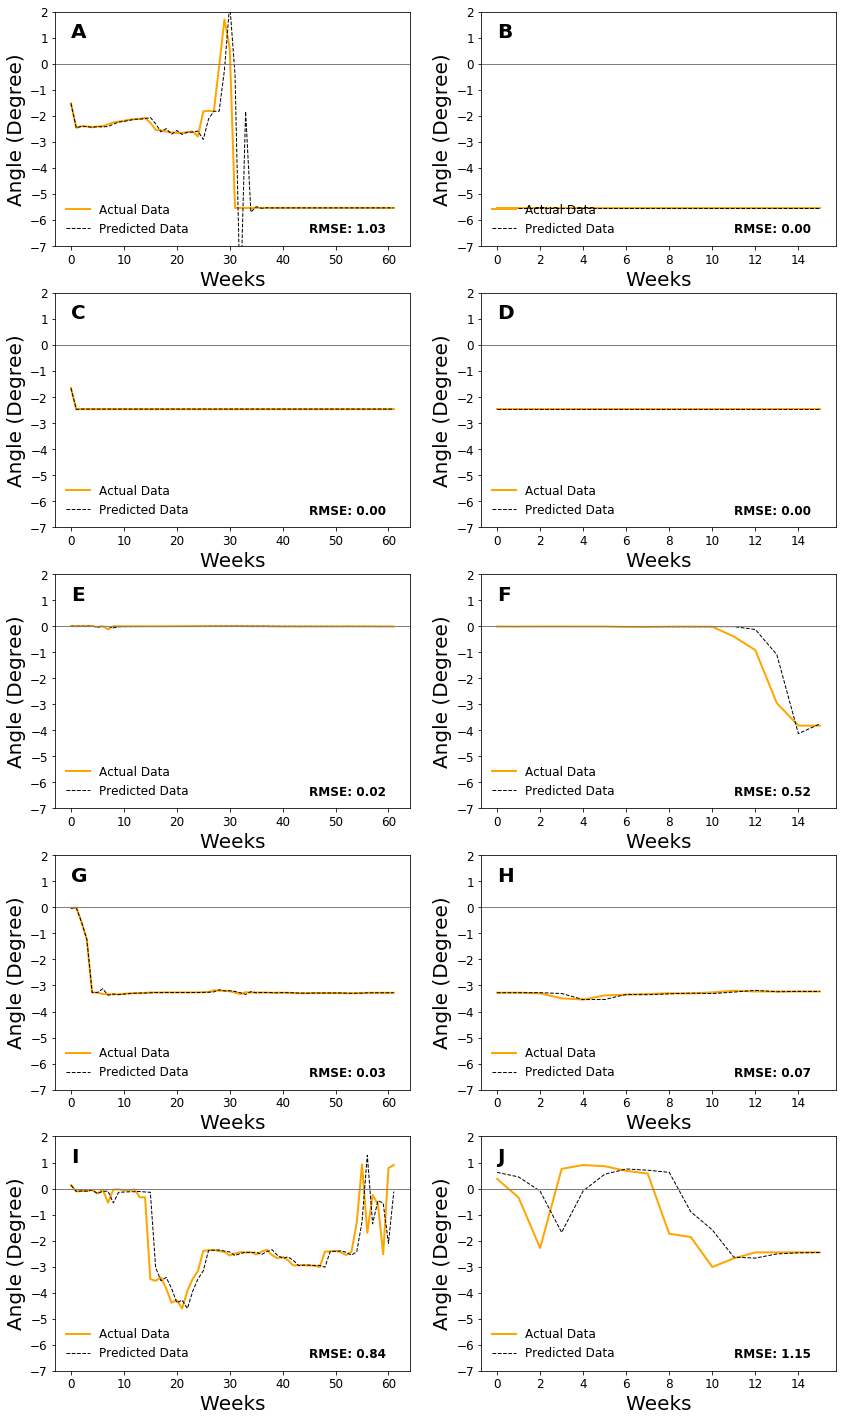

In [35]:
best_model(data1,data2,data3,data4,data5,scores)